In [ ]:
import cv2
import os
import numpy as np
import time
import mediapipe as mp

# Setup MediaPipe Holistic
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
mp_drawing = mp.solutions.drawing_utils

# Parameters - UPDATED AS REQUESTED
actions = ['hello', 'please', 'name', 'fine', 'no']  # Your 5 actions
num_videos = 50  # Changed from 30 to 50
seconds_per_video = 4  # Changed from 5 to 3
fps = 15
frames_per_video = fps * seconds_per_video  # Now 45 frames (15fps * 3s)

# Paths
BASE_DIR = "Final project/modue2_action"
DATASET_DIR = os.path.join(BASE_DIR, "action_dataset")
os.makedirs(DATASET_DIR, exist_ok=True)

def extract_keypoints(results):
    """Extracts and concatenates pose, left hand, and right hand landmarks"""
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33, 4))
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21, 3))
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21, 3))
    return np.concatenate([pose.flatten(), lh.flatten(), rh.flatten()])

# Webcam setup
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Webcam not accessible")
    exit()

cv2.namedWindow("KSL Action Collector", cv2.WINDOW_NORMAL)
cv2.resizeWindow("KSL Action Collector", 800, 600)

for action in actions:
    action_path = os.path.join(DATASET_DIR, action)
    os.makedirs(action_path, exist_ok=True)

    print(f"\n Recording action: {action} ({num_videos} videos @ {seconds_per_video}s each)")
    
    for video_num in range(num_videos):
        print(f" Video {video_num+1}/{num_videos} - {frames_per_video} frames")
        
        keypoints_sequence = []
        start_time = time.time()
        frame_count = 0

        while frame_count < frames_per_video:
            ret, frame = cap.read()
            if not ret:
                print("Frame capture error - retrying...")
                continue
            
            # Mirror flip and process
            frame = cv2.flip(frame, 1)
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic.process(rgb)

            # Visual feedback
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
            mp_drawing.draw_landmarks(frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
            mp_drawing.draw_landmarks(frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

            # Store keypoints
            keypoints = extract_keypoints(results)
            keypoints_sequence.append(keypoints)

            # Display info
            elapsed = time.time() - start_time
            remaining = max(0, seconds_per_video - elapsed)
            
            cv2.putText(frame, f"ACTION: {action.upper()}", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            cv2.putText(frame, f"Video: {video_num+1}/{num_videos}", (10, 70),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
            cv2.putText(frame, f"Time: {remaining:.1f}s | Frames: {frame_count}/{frames_per_video}", (10, 110),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 200, 255), 2)
            
            cv2.imshow("KSL Action Collector", frame)
            
            frame_count += 1
            if cv2.waitKey(1) & 0xFF == 27:  # ESC to exit
                break

        # Save only complete sequences
        if len(keypoints_sequence) == frames_per_video:
            npy_path = os.path.join(action_path, f"video_{video_num}.npy")
            np.save(npy_path, keypoints_sequence)
            print(f" Saved {npy_path} ({len(keypoints_sequence)} frames)")
        else:
            print(f"⚠️ Discarded incomplete recording ({len(keypoints_sequence)} frames)")
            
        # Brief pause between videos
        if video_num < num_videos - 1:
            print(" Preparing next video in 2 seconds...")
            time.sleep(2)

print("\n Data collection complete! Collected:")
for action in actions:
    action_path = os.path.join(DATASET_DIR, action)
    print(f"  - {action}: {len(os.listdir(action_path))} videos")

cap.release()
cv2.destroyAllWindows()
holistic.close()

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load all .npy files
X, y = [], []
for action_idx, action in enumerate(actions):
    action_dir = os.path.join(DATASET_DIR, action)
    for npy_file in sorted(os.listdir(action_dir)):
        if npy_file.endswith('.npy'):
            sequence = np.load(os.path.join(action_dir, npy_file))
            X.append(sequence)
            y.append(action_idx)

X = np.array(X)
y = np.array(y)

# Train-val-test split (60-20-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

print(f"Shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")




Shapes - Train: (150, 60, 258), Val: (50, 60, 258), Test: (50, 60, 258)


✅ Dataset size after augmentation: (750, 60, 258), Labels: (750,)
🧪 Splits -> Train: (450, 60, 258), Val: (150, 60, 258), Test: (150, 60, 258)


/home/shady/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        82,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,085 (742.52 KB)

 Trainable params: 190,085 (742.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3360 - loss: 1.5406 - val_accuracy: 0.2933 - val_loss: 1.3245
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.4419 - loss: 1.3326 - val_accuracy: 0.5067 - val_loss: 1.3128
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.3833 - loss: 1.6843 - val_accuracy: 0.3733 - val_loss: 1.5103
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.4356 - loss: 1.3710 - val_accuracy: 0.5000 - val_loss: 1.3683
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.3896 - loss: 1.3870 - val_accuracy: 0.4133 - val_loss: 0.9725
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4340 - loss: 1.1190 - val_accuracy: 0.2400 - val_loss: 1.4560
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3579 - loss: 1.3832 - val_accuracy: 0.5467 - val_loss: 1.0062
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5646 - loss: 0.9829 - val_accuracy: 0.5333

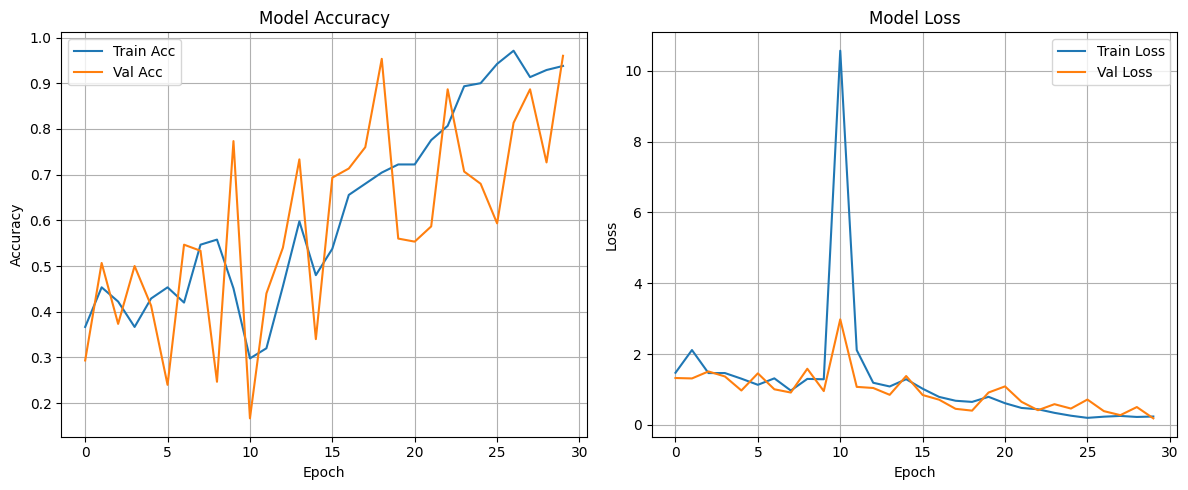

💾 Model and label map saved to 'Final project/module2_action/models'!


In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import random
from scipy.interpolate import interp1d

# --- SETTINGS ---
actions = ['hello', 'please', 'name', 'fine', 'no']
DATASET_DIR = "Final project/modue2_action/action_dataset"
SEQUENCE_LENGTH = 60
FEATURE_DIM = 258
NUM_CLASSES = len(actions)

# --- AUGMENTATION FUNCTIONS ---

def add_noise(sequence, noise_factor=0.01):
    return sequence + noise_factor * np.random.randn(*sequence.shape)

def time_warp(sequence, target_len=60):
    original_len = sequence.shape[0]
    f = interp1d(np.linspace(0, 1, original_len), sequence, axis=0, kind='linear')
    return f(np.linspace(0, 1, target_len))

# --- LOAD AND AUGMENT DATA ---

X, y = [], []

for action_idx, action in enumerate(actions):
    action_dir = os.path.join(DATASET_DIR, action)
    for npy_file in sorted(os.listdir(action_dir)):
        if npy_file.endswith('.npy'):
            sequence = np.load(os.path.join(action_dir, npy_file))
            X.append(sequence)
            y.append(action_idx)

            # Augmentations
            X.append(add_noise(sequence))
            y.append(action_idx)

            warped = time_warp(sequence, target_len=SEQUENCE_LENGTH)
            X.append(warped)
            y.append(action_idx)

X = np.array(X)
y = np.array(y)

print(f"✅ Dataset size after augmentation: {X.shape}, Labels: {y.shape}")

# --- SPLIT DATA (60/20/20) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

print(f"🧪 Splits -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# --- ONE-HOT ENCODE LABELS ---
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)

# --- BUILD LSTM MODEL ---
model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(SEQUENCE_LENGTH, FEATURE_DIM)),
    Dropout(0.3),
    LSTM(128, return_sequences=False, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- TRAIN THE MODEL ---
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=30,
    batch_size=16
)

# --- EVALUATE ON TEST SET ---
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\n🎯 Final Test Accuracy: {test_acc:.2%}")

import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# --- SAVE MODEL & LABEL MAP ---
MODEL_DIR = "Final project/module2_action/models"
os.makedirs(MODEL_DIR, exist_ok=True)

model.save(os.path.join(MODEL_DIR, "ksl_lstm_model.h5"))
np.save(os.path.join(MODEL_DIR, "label_map.npy"), np.array(actions))
print(f"Model and label map saved to '{MODEL_DIR}'!")



In [2]:
#exec

import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
from collections import deque

# --- Load model & labels ---
model = tf.keras.models.load_model("Final project/module2_action/models/ksl_lstm_model.h5")
label_map = np.load("Final project/module2_action/models/label_map.npy")

# --- Mediapipe setup ---
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# --- Keypoint extraction ---
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33, 4))
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21, 3))
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21, 3))
    return np.concatenate([pose.flatten(), lh.flatten(), rh.flatten()])

# Initialize buffer 
sequence = deque(maxlen=60)
threshold = 0.8  # Confidence threshold
predicted_action = ""

#  Webcam setup 
cap = cv2.VideoCapture(0)
cv2.namedWindow("KSL Real-Time Sign Detection", cv2.WINDOW_NORMAL)
cv2.resizeWindow("KSL Real-Time Sign Detection", 900, 700)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print(" Webcam not available")
        break

    # Flip and convert frame
    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(rgb)

    # Draw landmarks
    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

    # Extract keypoints and maintain a rolling sequence of 60
    keypoints = extract_keypoints(results)
    sequence.append(keypoints)
    if len(sequence) > 60:
        sequence.pop(0)

    # Status text
    if len(sequence) < 60:
        frames_needed = 60 - len(sequence)
        cv2.putText(frame,
            f"Collecting frames: {len(sequence)}/60 (Need {frames_needed} more)",
            (10, 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 255), 2)
        predicted_action = '...'
    else:
        # Predict
        input_data = np.expand_dims(sequence, axis=0)
        probs = model.predict(input_data, verbose=0)[0]
        max_prob = np.max(probs)

        if max_prob > threshold:
            predicted_action = label_map[np.argmax(probs)]
            color = (0, 255, 0)  # Green for confident prediction
        else:
            predicted_action = 'Low confidence'
            color = (0, 165, 255)  # Orange for unsure

        # Display confidence
        cv2.putText(frame,
            f"Confidence: {max_prob*100:.1f}%",
            (10, 100),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color, 2)

    # Overlay prediction
    cv2.putText(frame,
        f"Detected: {predicted_action.upper()}",
        (10, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        color if predicted_action not in ['...', 'Low confidence'] else (0, 0, 255),
        3)

    # Show window
    cv2.imshow("KSL Real-Time Sign Detection", frame)

    # Exit on ESC key
    if cv2.waitKey(10) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()
holistic.close()


I0000 00:00:1748611780.364690    7683 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1748611780.366450   14136 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: Mesa Intel(R) UHD Graphics 620 (KBL GT2)


In [3]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import classification_report, confusion_matrix
# from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# # === Custom Learning Rate Scheduler ===
# def lr_schedule(epoch, lr):
#     if epoch < 50:
#         return 0.001
#     elif epoch < 100:
#         return 0.0005
#     else:
#         return 0.0001

# # === Directory and File Setup ===
# MODEL_DIR = "Final project/saved_models"
# os.makedirs(MODEL_DIR, exist_ok=True)
# model_path = os.path.join(MODEL_DIR, "ksl_lstm_model.h5")
# actions = ['hello', 'please', 'name', 'fine', 'no']

# model = Sequential([
#     LSTM(32, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dense(32, activation='relu'),
#     Dropout(0.5),
#     Dense(len(actions), activation='softmax')
# ])

# X_train_noisy = X_train + np.random.normal(0, 0.01, X_train.shape)

# model.compile(
#     optimizer=Adam(),
#     loss='sparse_categorical_crossentropy',  # Labels are integers, not one-hot
#     metrics=['accuracy']
# )

# # === Callbacks for Overfitting Protection ===
# callbacks = [
#     ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=10,
#         min_lr=1e-7,
#         verbose=1
#     ),
#     LearningRateScheduler(lr_schedule),
#     #Optional: Enable this if you want early interruption when no improvement
#     EarlyStopping(
#         monitor='val_loss',
#         patience=20,
#         restore_best_weights=True,
#         verbose=1
#     )
# ]

# # === Training ===
# print("🚀 Starting training...")
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=150,
#     batch_size=16,
#     callbacks=callbacks,
#     verbose=2
# )

# # === Visualization ===
# plt.figure(figsize=(18, 6))

# # Loss
# plt.subplot(1, 3, 1)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss Evolution')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Accuracy
# plt.subplot(1, 3, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy Evolution')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# # Learning Rate
# plt.subplot(1, 3, 3)
# if 'lr' in history.history:
#     plt.plot(history.history['lr'], label='Learning Rate')
# else:
#     plt.plot([lr_schedule(e, 0.001) for e in range(len(history.history['loss']))], label='Learning Rate')
# plt.title('Learning Rate Schedule')
# plt.xlabel('Epochs')
# plt.ylabel('LR')
# plt.yscale('log')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # === Evaluation ===
# print("\n📊 Evaluating model...")
# y_pred = model.predict(X_test)
# y_pred_labels = np.argmax(y_pred, axis=1)

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred_labels, target_names=actions))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_labels)
# plt.figure(figsize=(12, 10))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=actions, yticklabels=actions)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# # Save final model
# model.save(model_path)
# print(f"💾 Model saved to: {model_path}")


Class distribution: [18 18 18 18 18]


(array([18., 18., 18., 18., 18.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

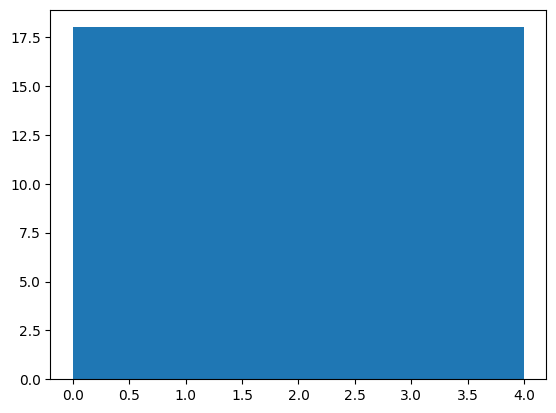

In [25]:
# print("Class distribution:", np.bincount(y_train))
# plt.hist(y_train, bins=len(actionss))

In [ ]:
# import cv2
# import numpy as np
# import mediapipe as mp
# from tensorflow.keras.models import load_model

# # === Load the trained model ===
# model = load_model('Final project/module2_action/models/ksl_lstm_model.h5')

# # Define the list of actions (must match training)
# actions = ['hello', 'please', 'name', 'fine', 'no']

# # === MediaPipe Hand setup ===
# mp_hands = mp.solutions.hands
# hands = mp_hands.Hands(static_image_mode=False,
#                        max_num_hands=1,
#                        min_detection_confidence=0.5,
#                        min_tracking_confidence=0.5)
# mp_drawing = mp.solutions.drawing_utils

# # === Webcam setup ===
# cap = cv2.VideoCapture(0)
# sequence = []
# seq_length = 30  # Number of frames in a sequence

# def extract_keypoints(results):
#     if results.multi_hand_landmarks:
#         hand = results.multi_hand_landmarks[0]
#         return np.array([[lm.x, lm.y, lm.z] for lm in hand.landmark]).flatten()
#     else:
#         return np.zeros(21 * 3)  # 21 landmarks, each with x, y, z

# predicted_action = ''

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Flip and convert image for MediaPipe
#     image = cv2.flip(frame, 1)
#     img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     results = hands.process(img_rgb)

#     # Draw hand landmarks
#     if results.multi_hand_landmarks:
#         for hand_landmarks in results.multi_hand_landmarks:
#             mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

#     # Extract keypoints and build sequence
#     keypoints = extract_keypoints(results)
#     sequence.append(keypoints)
#     sequence = sequence[-seq_length:]  # Keep only the latest N frames

#     # Predict when sequence is ready
#     if len(sequence) == seq_length:
#         input_data = np.expand_dims(sequence, axis=0)  # Shape: (1, 30, 63)
#         res = model.predict(input_data)[0]
#         predicted_action = actions[np.argmax(res)]

#         # Display result
#         cv2.putText(image, f'{predicted_action.upper()} ({np.max(res):.2f})',
#                     (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)

#     # Show the image
#     cv2.imshow('KSL Real-Time Prediction', image)

#     # Break on 'q' key
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()
